<a href="https://www.kaggle.com/code/michajurzak/chess-winner-classifier?scriptVersionId=166096374" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Online chess games
This notebook's topic is making a machine learning model to determine the winner of the game based on other parameters (excluding particular moves - the notation shows who won).  
*Made by Michał Jurzak*
## About dataset
There are 20,000 instances of online lichess games.

# Setup

In [1]:
import pandas as pd
import numpy as np
import io
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, randint
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
chess = pd.read_csv('/kaggle/input/online-chess-games/chess_games.csv')
chess.head()

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation
1,2,True,16,Resign,Black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation
2,3,True,61,Mate,White,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation
3,4,True,61,Mate,White,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,NaN,Zukertort Variation
4,5,True,95,Mate,White,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,NaN


In [3]:
chess.describe()

,game_id,turns,white_rating,black_rating,opening_moves
count,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000
mean,10029.500000,60.465999,1596.631868,1588.831987,4.816981
std,5790.390185,33.570585,291.253376,291.036126,2.797152
min,1.000000,1.000000,784.000000,789.000000,1.000000
25%,5015.250000,37.000000,1398.000000,1391.000000,3.000000
50%,10029.500000,55.000000,1567.000000,1562.000000,4.000000
75%,15043.750000,79.000000,1793.000000,1784.000000,6.000000
max,20058.000000,349.000000,2700.000000,2723.000000,28.000000


In [4]:
chess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

It seems like there are some variations regarding opening, because There are null values in opening_response and opening_variation. We will take a closer look later.

In [5]:
chess[['opening_fullname']].value_counts()

opening_fullname                                                                  
Van't Kruijs Opening                                                                  368
Sicilian Defense                                                                      358
Sicilian Defense: Bowdler Attack                                                      296
Scotch Game                                                                           271
French Defense: Knight Variation                                                      271
                                                                                     ... 
Queen's Gambit Accepted: Bogoljubov Defense                                             1
Queen's Gambit Accepted: Central Variation |  Rubinstein Defense                        1
Queen's Gambit Accepted: Central Variation |  Rubinstein Defense |  Yefimov Gambit      1
Queen's Gambit Accepted: Deferred Variation                                             1
Zukertort Opening

In [6]:
chess[['opening_response']].value_counts()

opening_response
Declined            503
Accepted            453
Refused             251
dtype: int64

It seems like the opening_fullname for our purpose is the most useful as it contains opening_code, shortname, response and variation.

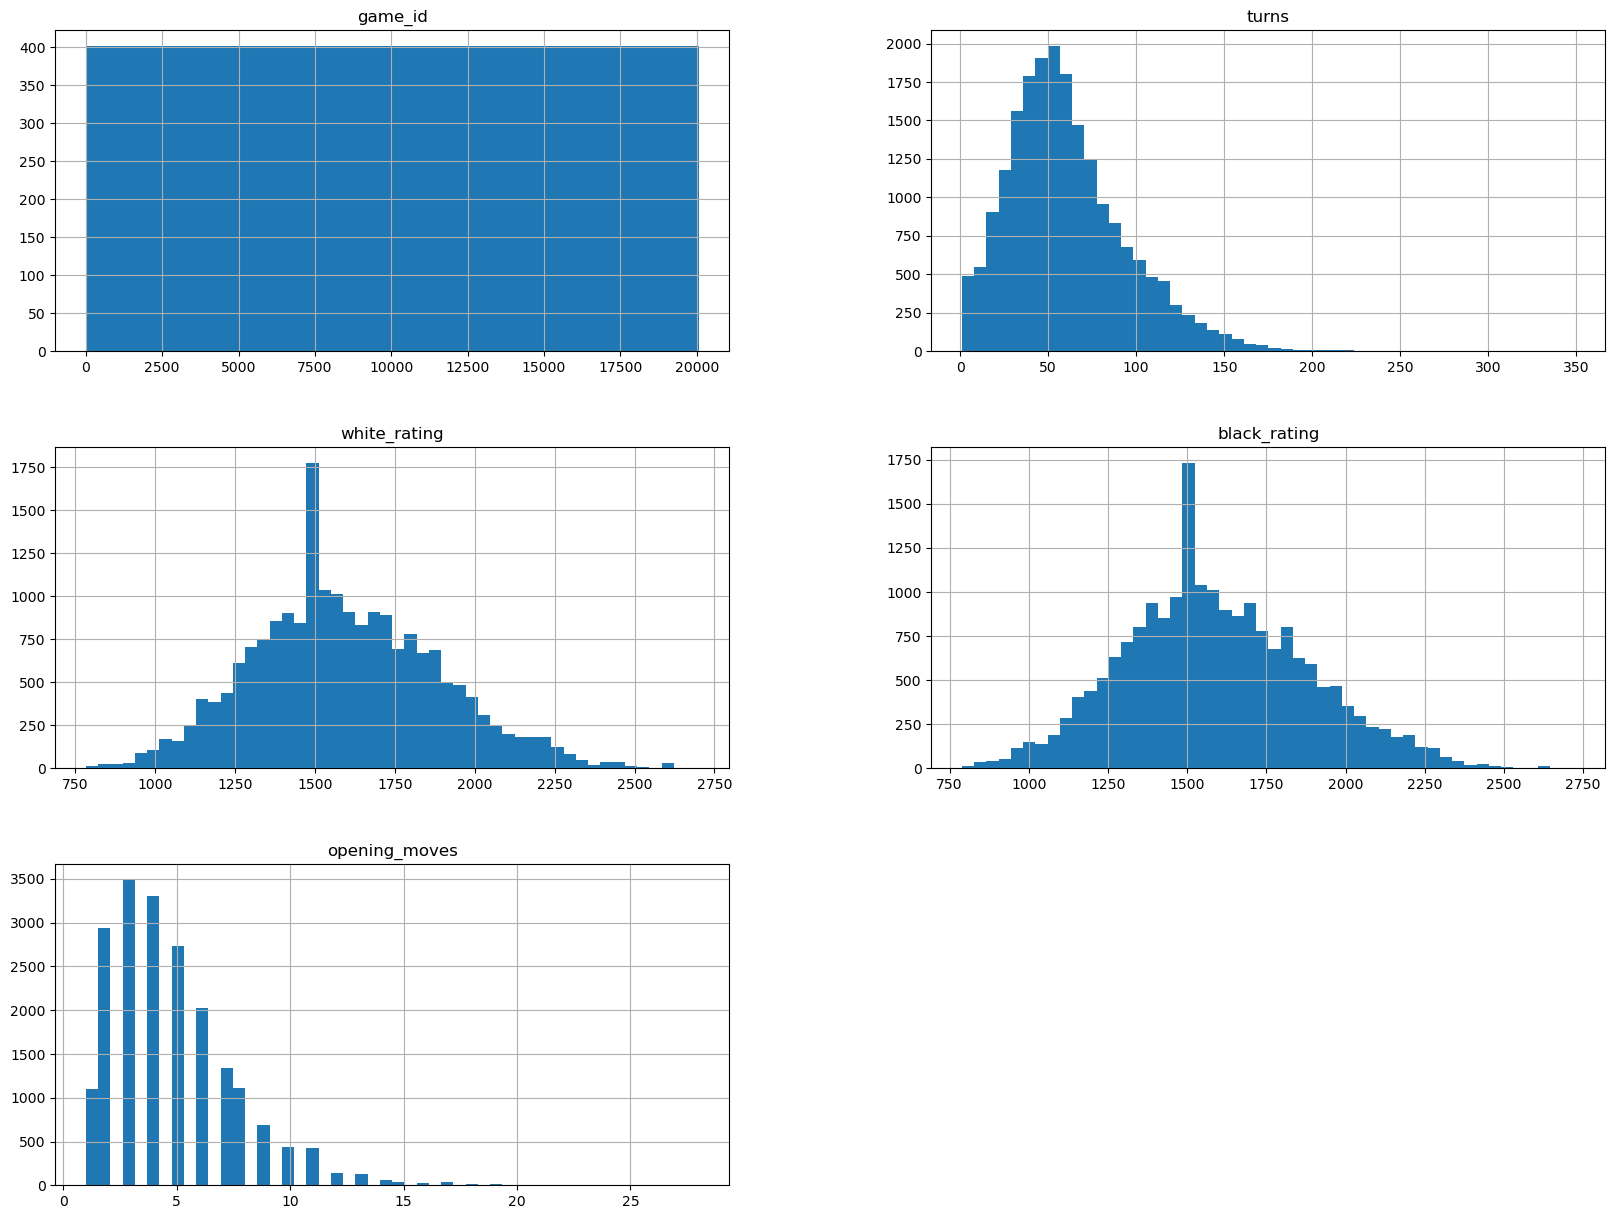

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
chess.hist(bins=50, figsize=(20,15))
plt.show()

The unnatural rise of values at 1500 is probably caused by the fact that Lichess's staring rating is 1500, thus other people fall in either direction later.

<Axes: >

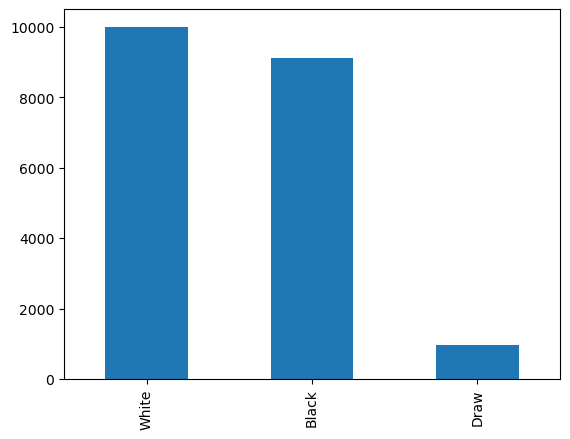

In [8]:
chess.winner.value_counts().plot(kind='bar')

White is slightly more likely to win than black. There is also some room for a draw.

I think it would be smart to also see the percentage of games that were won by black, white, or the games that were drawn.

In [9]:
chess.winner.value_counts()

White    10001
Black     9107
Draw       950
Name: winner, dtype: int64

The column victory_status has to be dropped due to the fact that it shows us one of the outcoms - draw. It than could proceed and have 100% accuracy on this category.

# Dividing dataset

In [10]:
chess.shape

(20058, 17)

In [11]:
train_set, test_set = train_test_split(chess, test_size=0.2, random_state=0)

In [12]:
X_train, y_train = train_set.loc[:, train_set.columns != 'winner'], train_set[['winner']]
print(X_train.shape, y_train.shape)

(16046, 16) (16046, 1)


In [13]:
X_test, y_test = test_set.loc[:, test_set.columns != 'winner'], test_set[['winner']]
print(X_test.shape, y_test.shape)

(4012, 16) (4012, 1)


In [14]:
X, y = chess.loc[:, chess.columns != 'winner'], chess[['winner']]

In [15]:
print(X.shape, y.shape)

(20058, 16) (20058, 1)


Now we will not touch X_test and y_test for a while in order not to fall into snooping bias.

# Data exploration and transformation

First, let's remove what we know is not needed

In [16]:
X_train.iloc[0]

game_id                                                          17844
rated                                                             True
turns                                                               86
victory_status                                                  Resign
time_increment                                                     7+2
white_id                                                   rajinikanth
white_rating                                                      1541
black_id                                                     smilsydov
black_rating                                                      2219
moves                d4 Nf6 Nc3 d5 Bg5 Nbd7 e3 g6 Bb5 c6 Be2 h6 Bxf...
opening_code                                                       D01
opening_moves                                                        5
opening_fullname                                Richter-Veresov Attack
opening_shortname                               Richter-Veresov Attack
openin

let's remove players id, moves and mentioned before opening-related columns that aren't opening_shortname (fullname opening could be too misleading, shortname could generalize better).  
Let us keep though the opening_moves.

In [17]:
X_train = X_train.drop(['white_id', 'black_id', 'moves', 'opening_code', 'opening_fullname','opening_response', 'opening_variation'], axis=1)

In [18]:
X_train.shape

(16046, 9)

In [19]:
X_train.head()

,game_id,rated,turns,victory_status,time_increment,white_rating,black_rating,opening_moves,opening_shortname
17843,17844,True,86,Resign,7+2,1541,2219,5,Richter-Veresov Attack
5518,5519,True,78,Resign,10+0,1818,1860,4,Queen's Pawn Game
7699,7700,True,100,Resign,10+0,1635,1574,3,Sicilian Defense
17006,17007,True,66,Mate,10+10,1364,1632,3,Queen's Gambit
1205,1206,True,99,Mate,10+0,1885,1607,2,Owen Defense


array([[<Axes: xlabel='turns', ylabel='turns'>,
        <Axes: xlabel='white_rating', ylabel='turns'>,
        <Axes: xlabel='black_rating', ylabel='turns'>,
        <Axes: xlabel='opening_moves', ylabel='turns'>],
       [<Axes: xlabel='turns', ylabel='white_rating'>,
        <Axes: xlabel='white_rating', ylabel='white_rating'>,
        <Axes: xlabel='black_rating', ylabel='white_rating'>,
        <Axes: xlabel='opening_moves', ylabel='white_rating'>],
       [<Axes: xlabel='turns', ylabel='black_rating'>,
        <Axes: xlabel='white_rating', ylabel='black_rating'>,
        <Axes: xlabel='black_rating', ylabel='black_rating'>,
        <Axes: xlabel='opening_moves', ylabel='black_rating'>],
       [<Axes: xlabel='turns', ylabel='opening_moves'>,
        <Axes: xlabel='white_rating', ylabel='opening_moves'>,
        <Axes: xlabel='black_rating', ylabel='opening_moves'>,
        <Axes: xlabel='opening_moves', ylabel='opening_moves'>]],
      dtype=object)

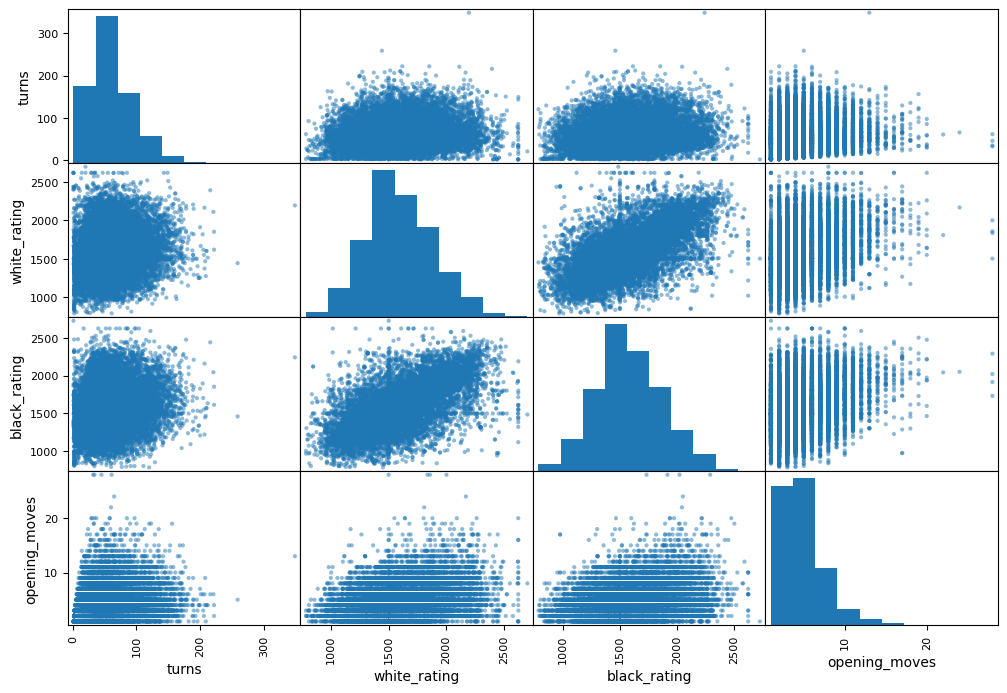

In [20]:
from pandas.plotting import scatter_matrix
# Let's focus on the most promising features
attributes = ["turns", "white_rating", "black_rating", "opening_moves"]
scatter_matrix(X_train[attributes], figsize=(12, 8))

Seems like the quantitative data isn't very helpful. However we can see some anomalies here and there.  
First of all, there are some lines regarding ratings in the data, both colors around 1500, but not only. There is also visible cap of sort (2700-ish).  
The graphs regarding moves look like stripes, but that's because the values are not continuous, and the scale differs.  
  
Ratings are related but that is quite normal, due to the fact that the games match against similar ratings.

In [21]:
X_train

,game_id,rated,turns,victory_status,time_increment,white_rating,black_rating,opening_moves,opening_shortname
17843,17844,True,86,Resign,7+2,1541,2219,5,Richter-Veresov Attack
5518,5519,True,78,Resign,10+0,1818,1860,4,Queen's Pawn Game
7699,7700,True,100,Resign,10+0,1635,1574,3,Sicilian Defense
17006,17007,True,66,Mate,10+10,1364,1632,3,Queen's Gambit
1205,1206,True,99,Mate,10+0,1885,1607,2,Owen Defense
...,...,...,...,...,...,...,...,...,...
13123,13124,True,54,Resign,5+5,1966,1859,4,Rat Defense
19648,19649,False,120,Out of Time,10+0,1812,1834,2,Dutch Defense
9845,9846,True,51,Mate,5+5,1381,1583,3,Caro-Kann Defense
10799,10800,True,46,Resign,30+0,1431,1658,4,King's Knight Opening


## Dividing games by rated and unrated
Let's now see how ratings are when people match against people in unrated games.

Text(0.5, 1.0, 'Unrated games')

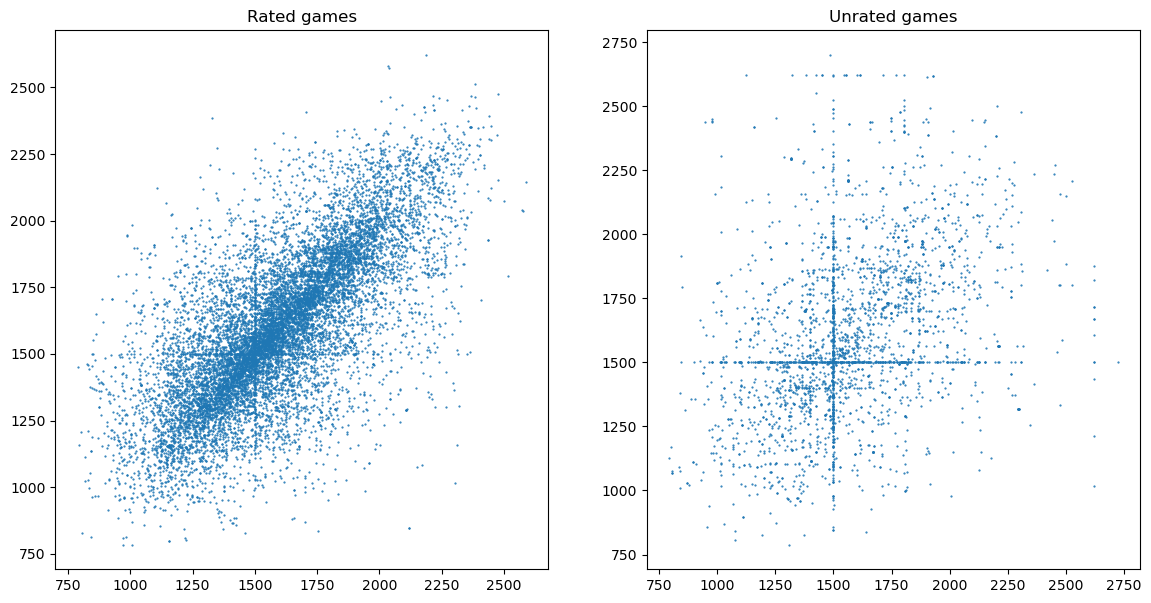

In [22]:
rated_train = train_set.loc[train_set['rated']==True]
unrated_train = train_set.loc[train_set['rated']==False]

fig, axis = plt.subplots(1, 2)
fig.set_size_inches(14, 7)
axis[0].scatter(x=rated_train['black_rating'], y=rated_train['white_rating'], s=0.3)
axis[0].set_title('Rated games')
axis[1].scatter(x=unrated_train['black_rating'], y=unrated_train['white_rating'], s=0.3)
axis[1].set_title('Unrated games')

You can see that in ranked games the players are most of the time facing an opponent that is at equal rating, the graph is also dense and linear.  
This cannot be said about unranked games, where players' rankings are not correlated much. Also it is worth noting, that there is much greater variance.  
That could be because maybe higher rated players want to play with their friends that are much lower at ranking.  

## Time formats
That being said, the rankings also are devided by something called *time format*. This is basically how much time each player has for the game. Every chess player has different number for classic, rapid, blitz and bullet formats.  
This fact alone can be importand by itself, thus let us see how the winnings at each time format present, because this may vary too.

In [23]:
X_train['time_increment'].value_counts()

10+0       6155
15+0       1065
15+15       681
5+5         590
5+8         549
           ... 
60+40         1
120+180       1
14+9          1
9+12          1
8+25          1
Name: time_increment, Length: 377, dtype: int64

As we can see, there are many (**377** !) time formats, although this is very misleading, due to the fact that many of them are not standard.  
Standard time formats in lichess are:  
  
Bullet: 1+0, 2+1, 3+0.  
Blitz: 3+2, 5+0, 5+3.  
Rapid: 10+0, 10+5, 15+10.  
Classical: 30+0, 30+20.  
  
(Time in minutes + time in seconds added after every move)

However the rating in each time controlls are the same, regardless of particular time (the same rating for 5+0 and 3+2).  
That's why it's fair to divide them and add category for each time format to generalize better.  
  
By [this exact formula on lichess.com](https://lichess.org/faq#time-controls) we can create a function that allows us for augmentation. Firstly we need to divide data to base and incremental time.

In [24]:
import re
from pandas import DataFrame

print(re.findall('\d+(?=\+)', X_train['time_increment'].loc[0]))
print(re.findall('(?<=\+)\d+', X_train['time_increment'].loc[0]))
# nice it works

['15']
['2']


In [25]:
import re
from pandas import DataFrame

def divide_time_format(df: DataFrame, time_format_col: object, base_time_col: str, inc_time_col: str):
    df[base_time_col] = df[time_format_col].apply(lambda x: re.findall('\d+(?=\+)', x)[0]).astype('int64')
    df[inc_time_col] = df[time_format_col].apply(lambda x: re.findall('(?<=\+)\d+', x)[0]).astype('int64')
    return df

In [26]:
X_train_divided = divide_time_format(X_train, 'time_increment', 'base_time_col', 'inc_time_col')

In [27]:
X_train_divided.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16046 entries, 17843 to 2732
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            16046 non-null  int64 
 1   rated              16046 non-null  bool  
 2   turns              16046 non-null  int64 
 3   victory_status     16046 non-null  object
 4   time_increment     16046 non-null  object
 5   white_rating       16046 non-null  int64 
 6   black_rating       16046 non-null  int64 
 7   opening_moves      16046 non-null  int64 
 8   opening_shortname  16046 non-null  object
 9   base_time_col      16046 non-null  int64 
 10  inc_time_col       16046 non-null  int64 
dtypes: bool(1), int64(7), object(3)
memory usage: 1.9+ MB


Looks like it was successful and we have no null values. Let's use the formula.
### Lichess Formula

In [28]:
def classify_time_format(base_time, inc_time):
    time_estimation = int(base_time)*60+40*int(inc_time)
    if time_estimation < 29:
        return "UltraBullet"
    elif 30 <= time_estimation and time_estimation < 179:
        return "Bullet"
    elif 180 <= time_estimation and time_estimation < 479:
        return "Blitz"
    elif 480 <= time_estimation and time_estimation < 1499:
        return "Rapid"
    else:
        return "Classical"
# Simple enough

In [29]:
X_train['time_format'] = X_train.apply(lambda x: classify_time_format(base_time=x['base_time_col'], inc_time=x['inc_time_col']), axis=1)
X_train.head()

,game_id,rated,turns,victory_status,time_increment,white_rating,black_rating,opening_moves,opening_shortname,base_time_col,inc_time_col,time_format
17843,17844,True,86,Resign,7+2,1541,2219,5,Richter-Veresov Attack,7,2,Rapid
5518,5519,True,78,Resign,10+0,1818,1860,4,Queen's Pawn Game,10,0,Rapid
7699,7700,True,100,Resign,10+0,1635,1574,3,Sicilian Defense,10,0,Rapid
17006,17007,True,66,Mate,10+10,1364,1632,3,Queen's Gambit,10,10,Rapid
1205,1206,True,99,Mate,10+0,1885,1607,2,Owen Defense,10,0,Rapid


Seems ok. Now let's count them.

In [30]:
X_train['time_format'].value_counts()

Rapid        13623
Classical     2420
Blitz            3
Name: time_format, dtype: int64

In [31]:
X_train.loc[X_train['base_time_col'] == 0][:5]

,game_id,rated,turns,victory_status,time_increment,white_rating,black_rating,opening_moves,opening_shortname,base_time_col,inc_time_col,time_format
9617,9618,True,2,Out of Time,0+16,1836,2340,2,Queen's Pawn Game,0,16,Rapid
9990,9991,False,18,Resign,0+180,1271,1500,4,Queen's Gambit,0,180,Classical
9610,9611,True,2,Out of Time,0+16,2159,1500,2,Scandinavian Defense,0,16,Rapid
2339,2340,True,60,Mate,0+25,1136,843,2,Hungarian Opening,0,25,Rapid
9613,9614,True,39,Draw,0+16,2002,2302,3,French Defense,0,16,Rapid


This data shows that there are no Bullet games (above are examples of some hilarious time formats like 0+180).  
What can be interesting - Blitz is insignificant and rapid and classical categories dominate the scene here.  
  
This is good because rapid and classical time formats are slower than the rest, thus we can assume more or less similar rating for each player in these formats.

## Qualitative variables
Lastly, let's look at the qualitative variables and change them for machine learning algorithm.

In [32]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

rated_encoder=OrdinalEncoder()
rated_ordinal=rated_encoder.fit_transform(X_train[['rated']])
print(rated_ordinal, rated_encoder.categories_)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]] [array([False,  True])]


In [33]:
X_train['opening_shortname'].value_counts()

Sicilian Defense      2116
French Defense        1154
Queen's Pawn Game      979
Italian Game           760
Queen's Gambit         728
                      ... 
Global Opening           1
Irish Gambit             1
Doery Defense            1
Australian Defense       1
Valencia Opening         1
Name: opening_shortname, Length: 127, dtype: int64

In [34]:
opening_encoder=OrdinalEncoder()
opening_ordinal=opening_encoder.fit_transform(X_train[['opening_shortname']])

time_format_encoder=OrdinalEncoder()
time_format_ordinal=time_format_encoder.fit_transform(X_train[['time_format']])

print(opening_ordinal, opening_encoder.categories_)
print(time_format_ordinal, time_format_encoder.categories_)

[[ 97.]
 [ 93.]
 [108.]
 ...
 [ 17.]
 [ 59.]
 [ 10.]] [array(['Alekhine Defense', 'Amar Opening', 'Amazon Attack',
       'Anderssen Opening', 'Australian Defense', 'Barnes Defense',
       'Barnes Opening', 'Benko Gambit', 'Benoni Defense', 'Bird Opening',
       "Bishop's Opening", 'Blackmar-Diemer Gambit',
       'Blumenfeld Countergambit', 'Bogo-Indian Defense', 'Borg Defense',
       'Budapest Defense', 'Canard Opening', 'Caro-Kann Defense',
       'Carr Defense', 'Catalan Opening', 'Center Game',
       'Clemenz Opening', 'Colle System', 'Crab Opening',
       'Creepy Crawly Formation', 'Czech Defense', 'Danish Gambit',
       'Doery Defense', 'Duras Gambit', 'Dutch Defense',
       'East Indian Defense', 'Elephant Gambit', 'English Defense',
       'English Opening', 'Englund Gambit', 'Englund Gambit Complex',
       'Four Knights Game', 'Franco-Benoni Defense', 'French Defense',
       "Gedult's Opening", 'Giuoco Piano', 'Global Opening',
       'Goldsmith Defense', 'Grob Openi

## Making Pipelines
The last step is to make custom transformers and a pipeline that will allow us to quickly transform the dataset

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class CleanerAndTimeDivider(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # dividing time_increment feature
        X_d = divide_time_format(X, 'time_increment', 'base_time_col', 'inc_time_col')
        # classifying time format
        X_d['time_format'] = X.apply(lambda x: classify_time_format(base_time=x['base_time_col'], inc_time=x['inc_time_col']), axis=1)
        # drop features
        cols_to_drop=['white_id', 'black_id', 'moves', 'opening_code', 'opening_fullname','opening_response', 'opening_variation', 'time_increment', 'victory_status']
        for col in cols_to_drop:
            if col in X:
                X_d = X.drop([col], axis=1)
        return X_d

clnr_time_divdr = CleanerAndTimeDivider()
X_extra = clnr_time_divdr.transform(X_train)
type(X_train)

pandas.core.frame.DataFrame

In [36]:
list(X_train.columns.difference(['rated','victory_status','opening_shortname','time_format']))

['base_time_col',
 'black_rating',
 'game_id',
 'inc_time_col',
 'opening_moves',
 'time_increment',
 'turns',
 'white_rating']

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
# use CleanerAndTimeDivider
# use Ordinal/OneHot Encoders for qualitative data
onehot_attribs = ['rated','opening_shortname','time_format']
scaling_attribs = list(X_train.columns.difference(onehot_attribs))
scaling_attribs.remove('time_increment')
scaling_attribs.remove('victory_status')
print(scaling_attribs)
print(list(X_train.columns))

num_prep = Pipeline([('scaler', StandardScaler())])
cat_prep = Pipeline([('onehot', OrdinalEncoder()),('scaler', StandardScaler())])

final_pipeline = Pipeline([
    ('clnr', CleanerAndTimeDivider()),
    ('transformer', ColumnTransformer([
        ('cat', cat_prep, onehot_attribs),
        ('num', num_prep, scaling_attribs)
    ]))
    
])

X_train_t=final_pipeline.fit_transform(X_train)
X_train_t
# X_train_prep = full_pipeline.fit_transform(X_train)

['base_time_col', 'black_rating', 'game_id', 'inc_time_col', 'opening_moves', 'turns', 'white_rating']
['game_id', 'rated', 'turns', 'victory_status', 'time_increment', 'white_rating', 'black_rating', 'opening_moves', 'opening_shortname', 'base_time_col', 'inc_time_col', 'time_format']


array([[ 0.49159145,  0.72026888,  0.42142962, ...,  0.07269479,
         0.75915371, -0.19342672],
       [ 0.49159145,  0.59930879,  0.42142962, ..., -0.285225  ,
         0.52097387,  0.75845594],
       [ 0.49159145,  1.05290913,  0.42142962, ..., -0.64314479,
         1.17596842,  0.12959484],
       ...,
       [ 0.49159145, -1.69893297,  0.42142962, ..., -0.64314479,
        -0.28288309, -0.74325064],
       [ 0.49159145, -0.428852  , -2.36598162, ..., -0.285225  ,
        -0.43174549, -0.57143066],
       [ 0.49159145, -1.91061313, -2.36598162, ..., -0.285225  ,
        -0.99742261, -1.84289847]])

In [38]:
final_pipeline.named_steps

{'clnr': CleanerAndTimeDivider(),
 'transformer': ColumnTransformer(transformers=[('cat',
                                  Pipeline(steps=[('onehot', OrdinalEncoder()),
                                                  ('scaler', StandardScaler())]),
                                  ['rated', 'opening_shortname', 'time_format']),
                                 ('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['base_time_col', 'black_rating', 'game_id',
                                   'inc_time_col', 'opening_moves', 'turns',
                                   'white_rating'])])}

In [39]:
DataFrame(X_train_t)

,0,1,2,3,4,5,6,7,8,9
0,0.491591,0.720269,0.421430,-0.399097,2.172013,1.349336,-0.227287,0.072695,0.759154,-0.193427
1,0.491591,0.599309,0.421430,-0.223927,0.938009,-0.775365,-0.366941,-0.285225,0.520974,0.758456
2,0.491591,1.052909,0.421430,-0.223927,-0.045069,-0.399383,-0.366941,-0.643145,1.175968,0.129595
3,0.491591,0.478349,0.421430,-0.223927,0.154296,1.205046,0.331327,-0.643145,0.163704,-0.801669
4,0.491591,0.175948,0.421430,-0.223927,0.068363,-1.518881,-0.366941,-1.001065,1.146196,0.988695
...,...,...,...,...,...,...,...,...,...,...
16041,0.491591,0.659789,0.421430,-0.515877,0.934572,0.535658,-0.017807,-0.285225,-0.193566,1.267043
16042,-2.034210,-1.336053,0.421430,-0.223927,0.848638,1.660500,-0.366941,-1.001065,1.771418,0.737838
16043,0.491591,-1.698933,0.421430,-0.515877,-0.014133,-0.029435,-0.017807,-0.643145,-0.282883,-0.743251
16044,0.491591,-0.428852,-2.365982,0.943870,0.243667,0.135024,-0.366941,-0.285225,-0.431745,-0.571431


# Training a binary classifier
## SGDClassifier
Let us start from SGDClassifier, this seems like one of the simplest models.

In [40]:
from sklearn.linear_model import SGDClassifier

chess_sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
chess_sgd.fit(X_train_t, y_train.values.ravel())

SGDClassifier(random_state=42)

### Cross Validation
For more robust validation I will use whole dataset, there won't be tuning of the models in this section of the notebook.  
However, when tuning comes, then the cross-validation will be performed only on training set.

In [41]:
X_validation = final_pipeline.fit_transform(X)

In [42]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(chess_sgd, X_validation, y.values.ravel(), cv=4)

And let's use confussion matrix to see how the model performed

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_mx = confusion_matrix(y, y_pred)
conf_mx

array([[4752,   31, 4324],
       [ 385,    9,  556],
       [2515,   33, 7453]])

We can visualize this

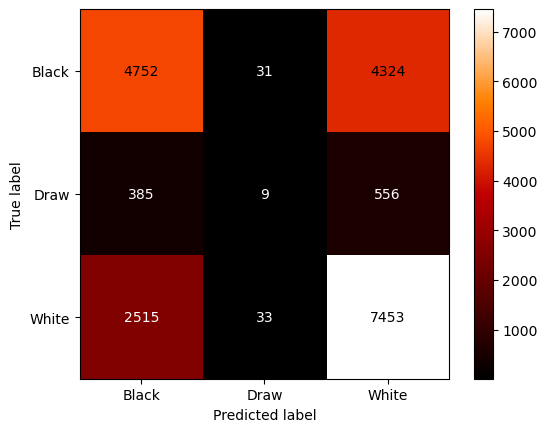

In [44]:
import matplotlib as mpl
disp_sgd = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=chess_sgd.classes_)
disp_sgd.plot(cmap=mpl.colormaps['gist_heat'])

Let's use precision and recall and maybe f1 score to see other metrics.

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
def display_scores(model, X_train, y_train, y_train_pred, avg="weighted", display_labels=False, cv=4, do_cross_val=True, do_accuracy=False):
    print(f'precision score: {precision_score(y_train, y_train_pred, average=None)} :{precision_score(y_train, y_train_pred, average="weighted")}')
    print(f'recall score: {recall_score(y_train, y_train_pred, average=None)} :{recall_score(y_train, y_train_pred, average="weighted")}')
    print(f'f1 score: {f1_score(y_train, y_train_pred, average=None)} :{f1_score(y_train, y_train_pred, average="weighted")}')
    if do_cross_val:
        print(f'cross val accuracy score: {cross_val_score(model, X_train, y_train.values.ravel(), cv=4)} : {pd.Series(cross_val_score(model, X_train, y_train.values.ravel(), cv=cv)).mean()}')
    if do_accuracy:
        print(f'accuracy score: {accuracy_score(y_train, y_train_pred)}')
    if display_labels:
        print("Black, Draw, White")
display_scores(chess_sgd, X_validation, y, y_pred, display_labels=True)

precision score: [0.62101411 0.12328767 0.60431363] :0.589113542630874
recall score: [0.52179642 0.00947368 0.74522548] :0.6089340911357064
f1 score: [0.56709828 0.01759531 0.66741291] :0.5910896441008018
cross val accuracy score: [0.60638086 0.60977069 0.61408057 0.60550459] : 0.6089341767278937
Black, Draw, White


These metrics definitely tell us something. The draws have quite low precision and recall. Possibly due to the fact that there are less drawn games.

Black is more likely to be correctly predicted and precision is slightly lower.

## DummyClassifier for reference

In [46]:
from sklearn.dummy import DummyClassifier

chess_dummy = DummyClassifier(strategy="stratified", random_state=0)
chess_dummy.fit(X_train_t, y_train)

DummyClassifier(random_state=0, strategy='stratified')

In [47]:
y_pred_dummy = cross_val_predict(chess_dummy, X_validation, y, cv=4)
dummy_conf_mx = confusion_matrix(y, y_pred_dummy)
dummy_conf_mx

array([[4063,  448, 4596],
       [ 400,   55,  495],
       [4395,  529, 5077]])

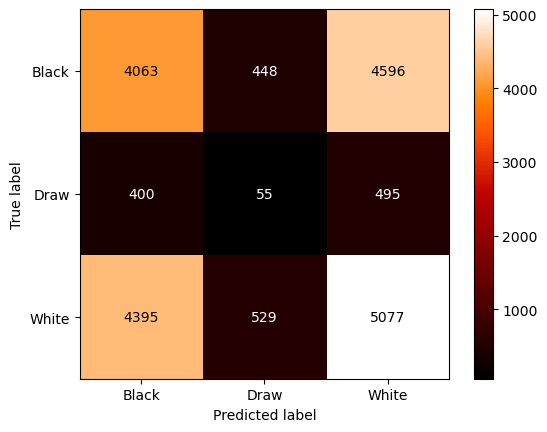

In [48]:
disp_dummy = ConfusionMatrixDisplay(confusion_matrix=dummy_conf_mx, display_labels=chess_sgd.classes_)
disp_dummy.plot(cmap=mpl.colormaps['gist_heat'])

In [49]:
display_scores(chess_dummy, X_validation, y, y_pred_dummy)

precision score: [0.45868142 0.05329457 0.49931157] :0.4597395795470065
recall score: [0.44614033 0.05789474 0.50764924] :0.45842058031708044
f1 score: [0.45232396 0.0554995  0.50344588] :0.45901890133316786
cross val accuracy score: [0.45782652 0.46141575 0.45731951 0.45712006] : 0.4584204605966703


By using as a reference a DummyClassifier with stratified strategy, we can see the scores if they were selected accordingly to the probability of the original labels.  
It's clear that SGDClassifier is better for this job than DummyClassifier although not by a large margin - we can try better models

## RandomForestClassifier

In [50]:
from sklearn.ensemble import RandomForestClassifier

chess_forest = RandomForestClassifier(n_estimators=100, random_state=0)
chess_forest.fit(X_train_t, y_train.values.ravel())

RandomForestClassifier(random_state=0)

In [51]:
y_pred_forest_proba = cross_val_predict(chess_forest, X_validation, y.values.ravel(), cv=4, method="predict_proba")
y_pred_forest_proba

array([[0.65, 0.05, 0.3 ],
       [0.64, 0.01, 0.35],
       [0.68, 0.  , 0.32],
       ...,
       [0.26, 0.29, 0.45],
       [0.17, 0.34, 0.49],
       [0.4 , 0.33, 0.27]])

The above function basically shows what percentage of estimators voted on certain value thus it makes the probability. That will be our go-to model when it comes to singular instance to predict.

In [52]:
y_pred_forest = cross_val_predict(chess_forest, X_validation, y.values.ravel(), cv=5)
forest_conf_mx = confusion_matrix(y, y_pred_forest)
forest_conf_mx

array([[6629,  210, 2268],
       [ 525,  105,  320],
       [4820,  224, 4957]])

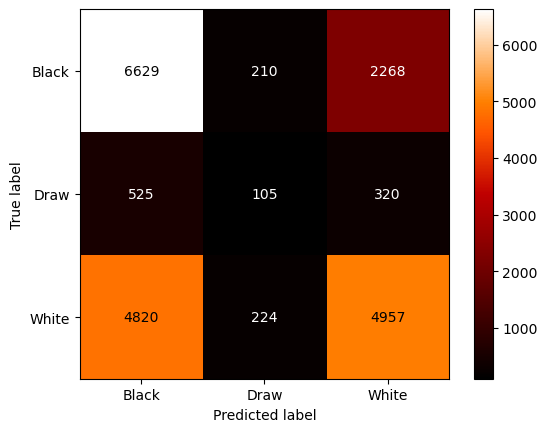

In [53]:
disp_forest = ConfusionMatrixDisplay(confusion_matrix=forest_conf_mx, display_labels=chess_sgd.classes_)
disp_forest.plot(cmap=mpl.colormaps['gist_heat'])

In [54]:
display_scores(chess_forest, X_validation, y, y_pred_forest)

precision score: [0.55361617 0.19480519 0.65699139] :0.5881652319264157
recall score: [0.72790161 0.11052632 0.49565043] :0.5828597068501347
f1 score: [0.62890755 0.14103425 0.56502907] :0.5739505067046703
cross val accuracy score: [0.45862413 0.63549352 0.64718787 0.54906262] : 0.5725920364156831


This is very interesting. The model works a lot better, however there are a few thing worth noting. There is overall high(er) precision score at the level of about 0.64.  
If it comes to recall both sides are similar (white slightly better), but draw as an option is substantially lower.  
This could be due to the fact that most of online games just end up by some party winning, thus making it hard to predict drawing chances.  
  
Drawing is also many times either by repetition of moves (3 times repeted position) or by mutual agreement. The dataset does not provide us with this information.

## LogisticRegression

In [55]:
from sklearn.linear_model import LogisticRegression

chess_logistic = LogisticRegression()
chess_logistic.fit(X_train_t, y_train.values.ravel())

LogisticRegression()

In [56]:
y_pred_logistic = cross_val_predict(chess_logistic, X_validation, y.values.ravel(), cv=4)
logistic_conf_mx = confusion_matrix(y, y_pred_logistic)
logistic_conf_mx

array([[5327,   10, 3770],
       [ 451,   15,  484],
       [2874,    9, 7118]])

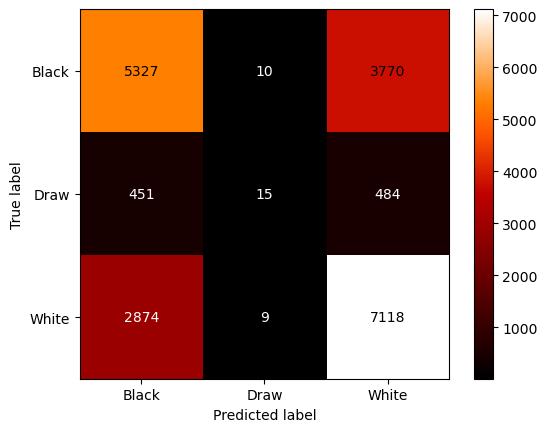

In [57]:
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=logistic_conf_mx, display_labels=chess_sgd.classes_)
disp_logistic.plot(cmap=mpl.colormaps['gist_heat'])

In [58]:
display_scores(chess_logistic, X_validation, y, y_pred_logistic)

precision score: [0.61569579 0.44117647 0.62592332] :0.6125295822365823
recall score: [0.58493467 0.01578947 0.71172883] :0.6211985242795892
f1 score: [0.59992117 0.0304878  0.66607402] :0.605935374429187
cross val accuracy score: [0.61834497 0.62871386 0.62106103 0.61667331] : 0.6211982918416669


## KNeighborsClassifier

In [59]:
from sklearn.neighbors import KNeighborsClassifier

chess_neighbors = KNeighborsClassifier(weights='distance')
chess_neighbors.fit(X_train_t, y_train.values.ravel())

KNeighborsClassifier(weights='distance')

In [60]:
y_pred_neighbors = cross_val_predict(chess_neighbors, X_validation, y.values.ravel(), cv=4)
neighbors_conf_mx = confusion_matrix(y, y_pred_neighbors)
neighbors_conf_mx

array([[4890,  128, 4089],
       [ 434,   42,  474],
       [3798,  136, 6067]])

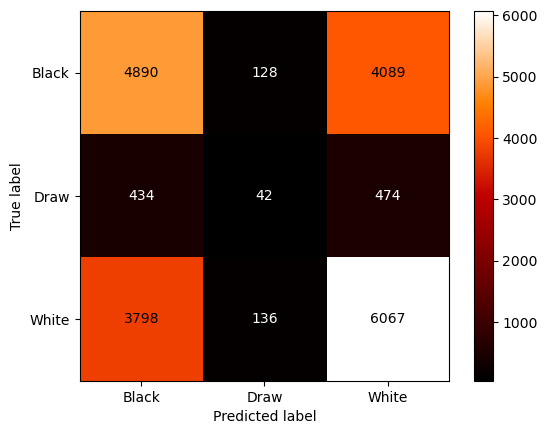

In [61]:
disp_kneighbors = ConfusionMatrixDisplay(confusion_matrix=neighbors_conf_mx, display_labels=chess_sgd.classes_)
disp_kneighbors.plot(cmap=mpl.colormaps['gist_heat'])

In [62]:
display_scores(chess_neighbors, X_validation, y, y_pred_neighbors)

precision score: [0.53606665 0.1372549  0.57074318] :0.534467728440681
recall score: [0.5369496  0.04421053 0.60663934] :0.5483597567055539
f1 score: [0.53650776 0.06687898 0.58814406] :0.5400109641196639
cross val accuracy score: [0.5449651  0.55493519 0.5436777  0.54986039] : 0.5483595981103359


## SVC
The last of the models I will try to compare is Support Vector Classification

In [63]:
from sklearn.svm import SVC

chess_svm = SVC() # let's check default values with rbf
chess_svm.fit(X_train_t, y_train.values.ravel())

SVC()

In [64]:
y_pred_svm = cross_val_predict(chess_svm, X_validation, y.values.ravel(), cv=4)
svm_conf_mx = confusion_matrix(y, y_pred_svm)
svm_conf_mx

array([[5353,    3, 3751],
       [ 459,    0,  491],
       [3076,    1, 6924]])

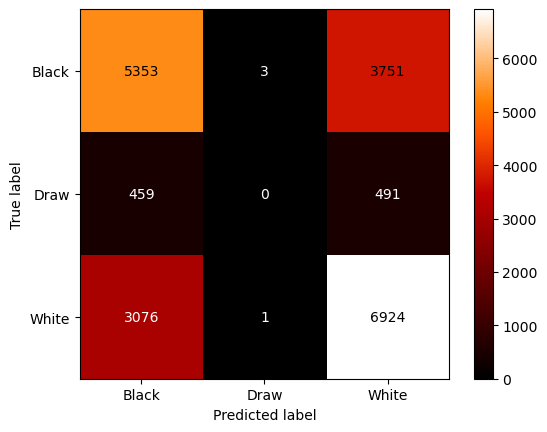

In [65]:
disp_svm = ConfusionMatrixDisplay(confusion_matrix=svm_conf_mx, display_labels=chess_sgd.classes_)
disp_svm.plot(cmap=mpl.colormaps['gist_heat'])

In [66]:
display_scores(chess_svm, X_validation, y, y_pred_svm)

precision score: [0.60227273 0.         0.62009672] :0.5826346119213589
recall score: [0.58778961 0.         0.69233077] :0.6120749825506032
f1 score: [0.59494304 0.         0.65422592] :0.5963236447197791
cross val accuracy score: [0.6109671  0.61655035 0.6170722  0.60370961] : 0.6120748146466066


# General comparison of the models

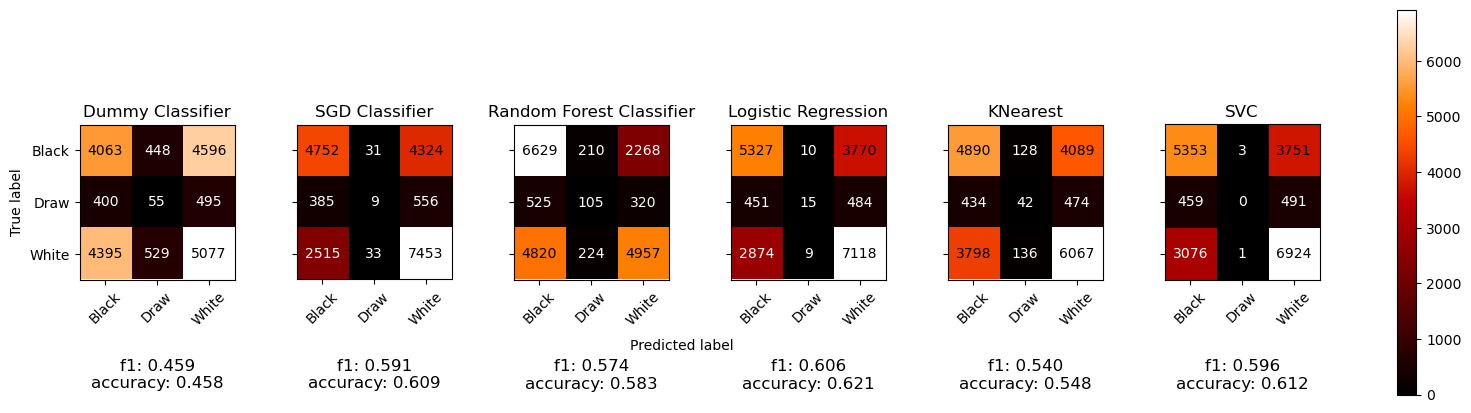

In [67]:
classifiers = {
    "Dummy Classifier": [disp_dummy, y_pred_dummy],
    "SGD Classifier": [disp_sgd, y_pred],
    "Random Forest Classifier": [disp_forest, y_pred_forest],
    "Logistic Regression": [disp_logistic, y_pred_logistic],
    "KNearest": [disp_kneighbors, y_pred_neighbors],
    "SVC": [disp_svm, y_pred_svm]
}
n = len(classifiers)

fig, ax = plt.subplots(1, n, figsize=(20, 5), sharey='row')

for i, (key, display) in enumerate(classifiers.items()):
    display[0].plot(ax=ax[i], xticks_rotation=45, cmap=mpl.colormaps['gist_heat'])
    display[0].ax_.set_title(key)
    display[0].im_.colorbar.remove()
    display[0].ax_.set_xlabel('')
    if i!=0:
        display[0].ax_.set_ylabel('')
    scores = f'f1: {f1_score(y, display[1], average="weighted"):.3f}\naccuracy: {accuracy_score(y, display[1]):0.3f}'
    display[0].ax_.text(0.5,-0.7, scores, size=12, ha="center", 
         transform=display[0].ax_.transAxes)
        
fig.text(0.4, 0.2, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


fig.colorbar(display[0].im_, ax=ax)
plt.show()

By the looks of things, the Logistic Regression model did the best, so let us focus on this model. Second best was SVC, though it is worth noting that no drawn game was detected.

# Hyperparameter tuning
## RandomForest
Although RandomForestClassifier did not perform as well as LogisticRegression, many times it has a great performance.  
We will used Randomized Search Cross Validation in order to search for the best hyperparameters.

In [68]:
from pprint import pprint

print('Parameters currently in use:\n')
pprint(chess_forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


Let us consider tuning the following parameters:  
n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap

In [69]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 11)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 380, 560, 740, 920, 1100, 1280, 1460, 1640, 1820, 2000]}


In [70]:
from sklearn.model_selection import RandomizedSearchCV

rf_random = RandomizedSearchCV(estimator = chess_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=0, n_jobs = -1)
rf_random.fit(X_train_t, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 380, 560, 740,
                                                         920, 1100, 1280, 1460,
                                                         1640, 1820, 2000]},
                   random_state=0, verbose=1)

In [71]:
rf_random.best_params_

{'n_estimators': 380,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [72]:
chess_forest_best = rf_random.best_estimator_

## LogisticRegression

In [73]:
print('Parameters currently in use:\n')
pprint(chess_logistic.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [74]:
logic_random_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]

In [75]:
lr_random = RandomizedSearchCV(estimator = chess_logistic, param_distributions = logic_random_grid, n_iter = 100, cv = 3, verbose=1, random_state=0, n_jobs = -1)
lr_random.fit(X_train_t, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     'none'],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'liblinear', 'sag',
                                                    'saga']}],
                   random_state=0, verbose=1)

In [76]:
lr_random.best_params_

{'solver': 'liblinear',
 'penalty': 'l1',
 'max_iter': 5000,
 'C': 0.03359818286283781}

In [77]:
chess_logistic_best = lr_random.best_estimator_

# Final evaluation on the test set

In [78]:
X_test_t = final_pipeline.fit_transform(X_test)

## RandomForest

In [79]:
y_pred_fin = chess_forest_best.predict(X_test_t)

In [80]:
y_pred_fin_proba = chess_forest_best.predict_proba(X_test_t)

In [81]:
display_scores(chess_forest_best, X_test_t, y_test, y_pred_fin, do_cross_val=False, do_accuracy=True)

precision score: [0.6477595  0.8        0.64269763] :0.6518918771740639
recall score: [0.61763115 0.04571429 0.72384306] :0.6453140578265204
f1 score: [0.63233666 0.08648649 0.68086113] :0.6325716698422216
accuracy score: 0.6453140578265204


In [82]:
fin_conf_mx = confusion_matrix(y_test, y_pred_fin)
fin_conf_mx

array([[1142,    0,  707],
       [  74,    8,   93],
       [ 547,    2, 1439]])

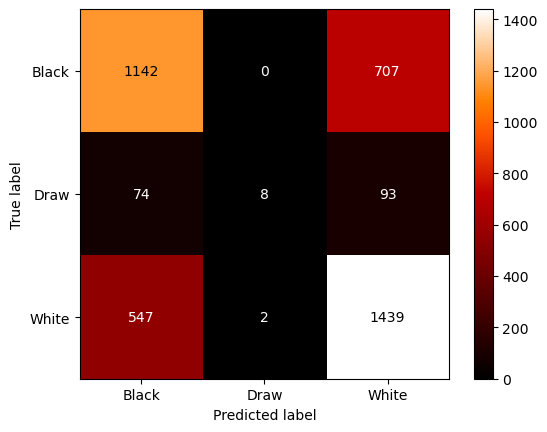

In [83]:
disp_fin = ConfusionMatrixDisplay(confusion_matrix=fin_conf_mx, display_labels=chess_sgd.classes_)
disp_fin.plot(cmap=mpl.colormaps['gist_heat'])

## LogisticRegression

In [84]:
y_pred_fin_lr = chess_logistic_best.predict(X_test_t)

In [85]:
y_pred_fin_proba_lr = chess_forest_best.predict_proba(X_test_t)

In [86]:
display_scores(chess_logistic_best, X_test_t, y_test, y_pred_fin_lr, do_cross_val=False, do_accuracy=True)

precision score: [0.63944344 0.5        0.62537123] :0.6263880677756082
recall score: [0.57166036 0.00571429 0.74144869] :0.6311066799601196
f1 score: [0.60365505 0.01129944 0.67848101] :0.6148942795641731
accuracy score: 0.6311066799601196


In [87]:
fin_conf_mx_lr = confusion_matrix(y_test, y_pred_fin_lr)
fin_conf_mx_lr

array([[1057,    0,  792],
       [  83,    1,   91],
       [ 513,    1, 1474]])

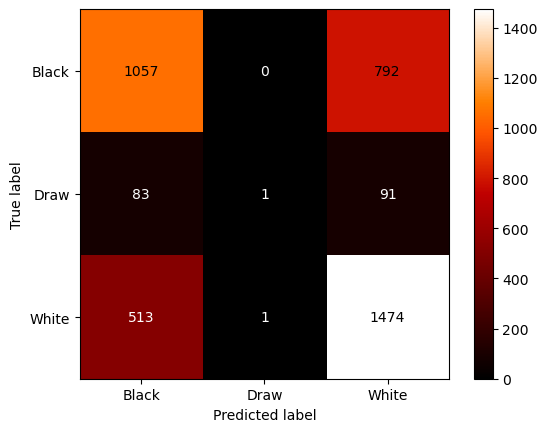

In [88]:
disp_fin_lr = ConfusionMatrixDisplay(confusion_matrix=fin_conf_mx_lr, display_labels=chess_logistic.classes_)
disp_fin_lr.plot(cmap=mpl.colormaps['gist_heat'])

# Summary

This notebook's purpose was to learn classification models. Provided models are not perfect solutions, they are based on general information from relatively small dataset (20,000 liches online games). For a better performing model more per-user data is needed.  
  
Thank you for reading this notebook and feel free to comment what would better be improved.